In [36]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot
from sklearn.metrics import mean_absolute_error, mean_squared_error
from prophet import Prophet
import warnings
warnings.filterwarnings("ignore")

In [37]:
# Set seaborn style for colorblind-friendly plots
sns.set_palette("colorblind")

In [38]:
# Step 1: Load the dataset
file_path = "C:/Users/gurob/Documents/Individual assignment Machine learning/200k youtube channel analytics/all_youtube_analytics.csv"
dataset = pd.read_csv(file_path)

In [39]:
# Step 2: Filter for a specific video ID and preprocess the data
selected_video_id = dataset['video_id'].iloc[0]
video_data = dataset[dataset['video_id'] == selected_video_id]

In [40]:
# Convert 'day' column to datetime and sort the data
video_data['day'] = pd.to_datetime(video_data['day'])
video_data = video_data.sort_values(by='day')

In [41]:
# Extract 'day' and 'views' for time series analysis and handle missing values
time_series_data = video_data[['day', 'views']].dropna().interpolate()

print(f"Dataset contains {len(time_series_data)} rows after preprocessing.")

Dataset contains 1893 rows after preprocessing.


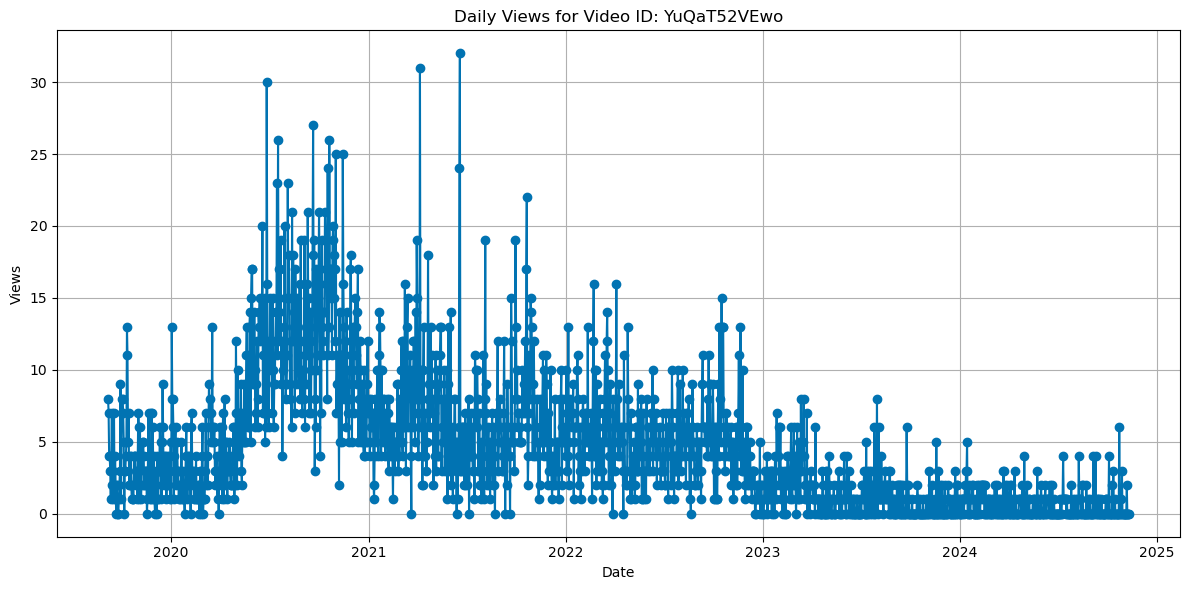

In [42]:
# Step 3: Visualize the time series
plt.figure(figsize=(12, 6))
plt.plot(time_series_data['day'], time_series_data['views'], label='Views', marker='o')
plt.title(f"Daily Views for Video ID: {selected_video_id}")
plt.xlabel("Date")
plt.ylabel("Views")
plt.grid(True)
plt.tight_layout()
plt.show()

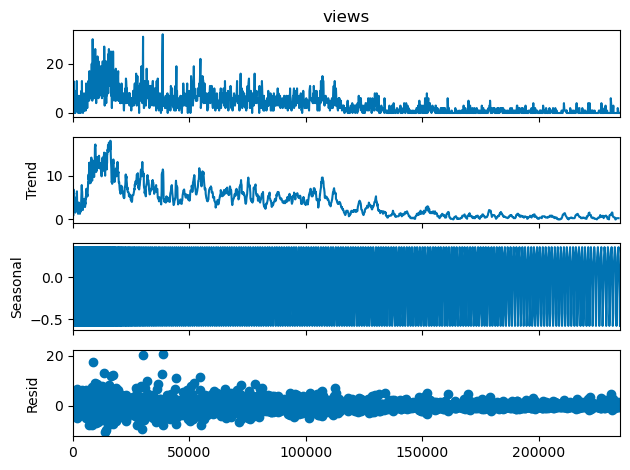

In [43]:
# Step 4: Decompose the time series into trend, seasonal, and residual components
result = seasonal_decompose(time_series_data['views'], model='additive', period=7)
result.plot()
plt.tight_layout()
plt.show()

In [44]:
# Step 5: Train-test split
train_size = int(0.8 * len(time_series_data))
train_data = time_series_data[:train_size]
test_data = time_series_data[train_size:]

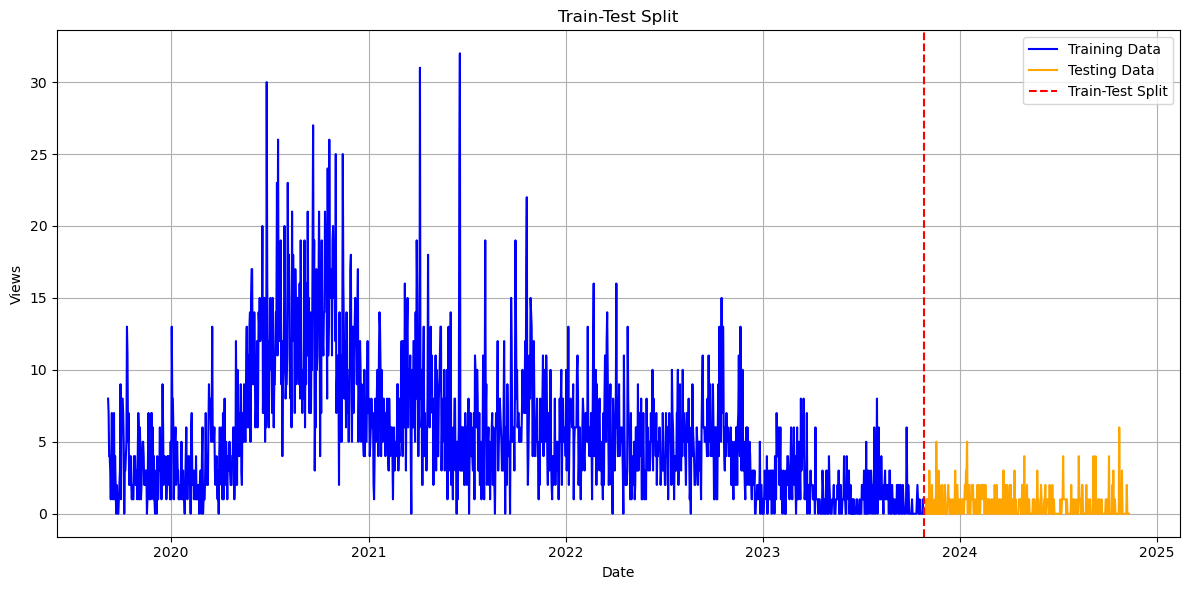

In [45]:
# Visualize train-test split
plt.figure(figsize=(12, 6))
plt.plot(train_data['day'], train_data['views'], label='Training Data', color='blue')
plt.plot(test_data['day'], test_data['views'], label='Testing Data', color='orange')
plt.axvline(train_data['day'].iloc[-1], color='red', linestyle='--', label='Train-Test Split')
plt.title("Train-Test Split")
plt.xlabel("Date")
plt.ylabel("Views")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

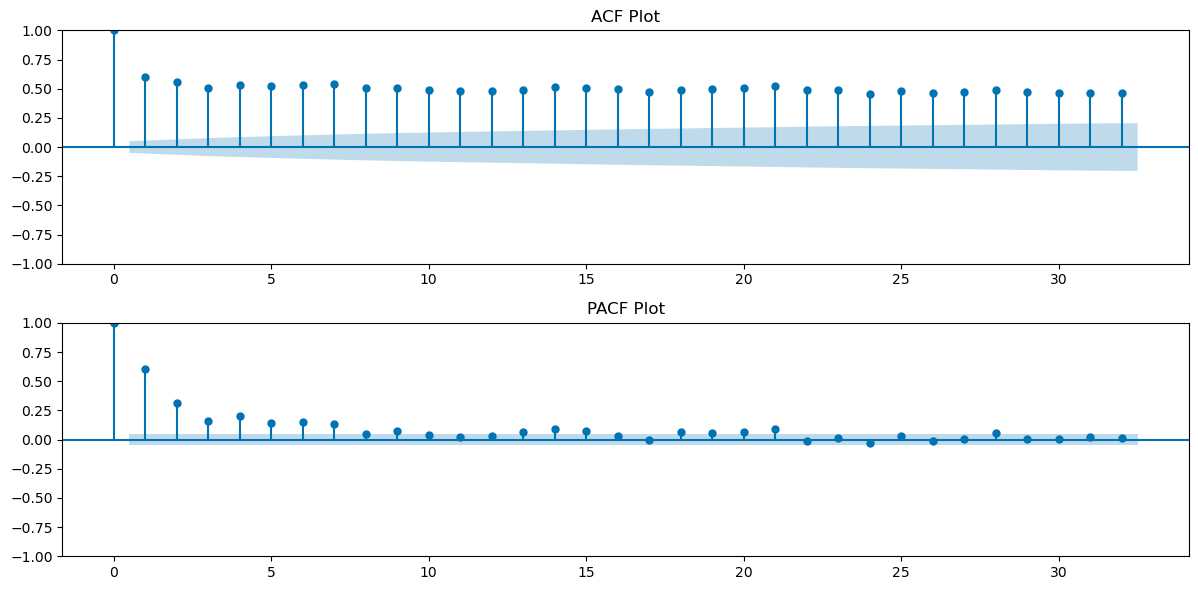

In [46]:
# Step 6: ACF and PACF plots for ARIMA parameter selection
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plot_acf(train_data['views'], ax=plt.gca(), title="ACF Plot")
plt.subplot(2, 1, 2)
plot_pacf(train_data['views'], ax=plt.gca(), title="PACF Plot")
plt.tight_layout()
plt.show()

In [47]:
# Step 7: Train ARIMA model
train_views = train_data['views'].values
arima_model = ARIMA(train_views, order=(5, 1, 2))  # Parameters tuned based on ACF/PACF
arima_model_fit = arima_model.fit()

In [48]:
# Print ARIMA summary
print(arima_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1514
Model:                 ARIMA(5, 1, 2)   Log Likelihood               -3946.878
Date:                Thu, 12 Dec 2024   AIC                           7909.755
Time:                        14:14:02   BIC                           7952.330
Sample:                             0   HQIC                          7925.609
                               - 1514                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8400      0.019    -45.039      0.000      -0.877      -0.803
ar.L2          0.1982      0.029      6.732      0.000       0.140       0.256
ar.L3         -0.0059      0.033     -0.176      0.8

In [49]:
# Residual Analysis for ARIMA
residuals = arima_model_fit.resid

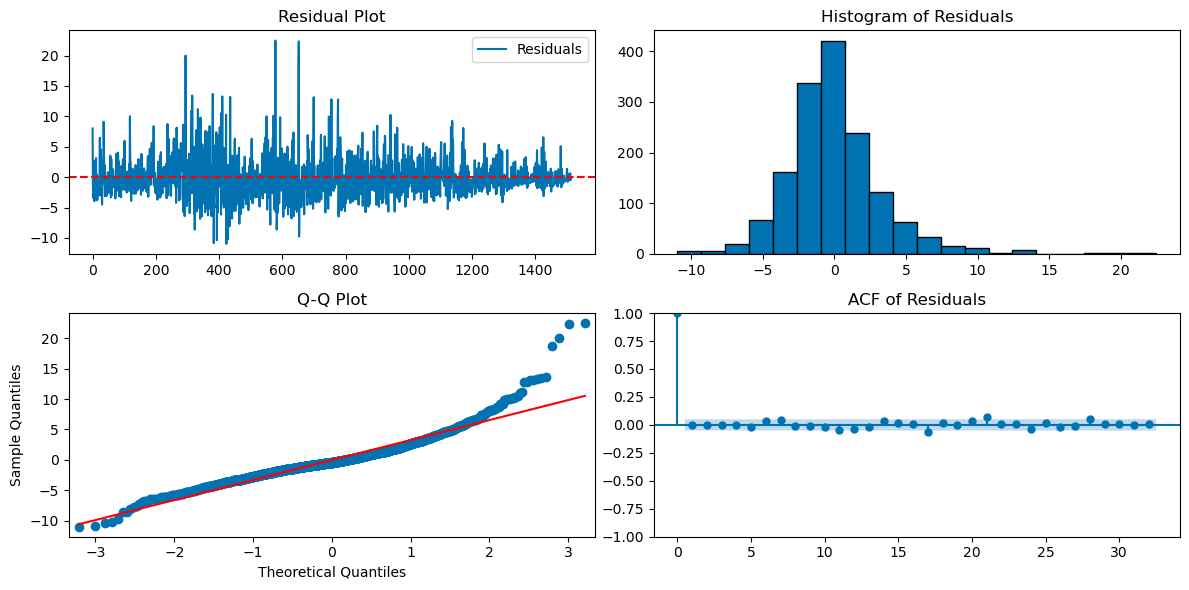

In [50]:
# Visualize residuals
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.plot(residuals, label='Residuals')
plt.axhline(0, color='red', linestyle='--')
plt.title("Residual Plot")
plt.legend()

plt.subplot(2, 2, 2)
plt.hist(residuals, bins=20, edgecolor='black')
plt.title("Histogram of Residuals")

plt.subplot(2, 2, 3)
qqplot(residuals, line='s', ax=plt.gca())
plt.title("Q-Q Plot")

plt.subplot(2, 2, 4)
plot_acf(residuals, ax=plt.gca(), title="ACF of Residuals")
plt.tight_layout()
plt.show()

In [51]:
# Forecast and evaluate ARIMA
forecast_steps = len(test_data)
forecast_arima = arima_model_fit.forecast(steps=forecast_steps)

mae_arima = mean_absolute_error(test_data['views'], forecast_arima)
mse_arima = mean_squared_error(test_data['views'], forecast_arima)
print(f"ARIMA MAE: {mae_arima:.2f}")
print(f"ARIMA MSE: {mse_arima:.2f}")

ARIMA MAE: 0.71
ARIMA MSE: 1.06


In [52]:
# Step 8: Prepare data for Prophet
prophet_data = time_series_data.rename(columns={"day": "ds", "views": "y"})

In [53]:
# Initialize and train the Prophet model
prophet_model = Prophet()
prophet_model.fit(prophet_data)

14:14:05 - cmdstanpy - INFO - Chain [1] start processing
14:14:05 - cmdstanpy - INFO - Chain [1] done processing


In [54]:
# Create future dataframe and forecast
future = prophet_model.make_future_dataframe(periods=len(test_data))
forecast_prophet = prophet_model.predict(future)

In [55]:
# Evaluate Prophet model
prophet_predicted = forecast_prophet.iloc[-len(test_data):]['yhat'].values
mae_prophet = mean_absolute_error(test_data['views'].values, prophet_predicted)
mse_prophet = mean_squared_error(test_data['views'].values, prophet_predicted)
print(f"Prophet MAE: {mae_prophet:.2f}")
print(f"Prophet MSE: {mse_prophet:.2f}")

Prophet MAE: 1.87
Prophet MSE: 4.98


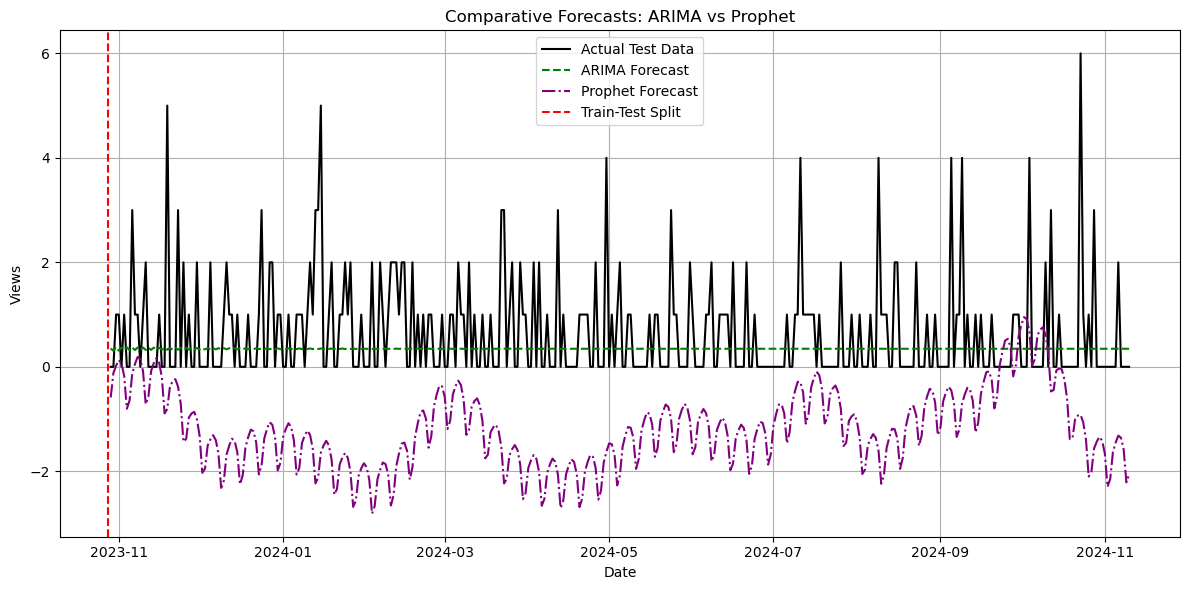

In [56]:
# Step 9: Compare forecasts
plt.figure(figsize=(12, 6))
plt.plot(test_data['day'], test_data['views'], label='Actual Test Data', color='black')
plt.plot(test_data['day'], forecast_arima, label='ARIMA Forecast', color='green', linestyle='--')
plt.plot(test_data['day'], prophet_predicted, label='Prophet Forecast', color='purple', linestyle='-.')
plt.axvline(train_data['day'].iloc[-1], color='red', linestyle='--', label='Train-Test Split')
plt.title("Comparative Forecasts: ARIMA vs Prophet")
plt.xlabel("Date")
plt.ylabel("Views")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()